In [1]:
import random, os, sys, shutil
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Loading Data

Insert the path to your data



In [2]:
#Read in csv
df = pd.read_csv("/Users/liangminghao/Desktop/Tomato.csv")

In [3]:
#See columns
df.columns

Index(['Date', 'Unit', 'Minimum', 'Maximum', 'Average', 'Market'], dtype='object')

In [4]:
#Summarise
df.describe()

,Minimum,Maximum,Average
count,2741.000000,2741.000000,2741.000000
mean,35.089748,41.281284,38.185516
std,16.648425,17.364135,16.970949
min,8.000000,12.000000,10.000000
25%,22.000000,30.000000,25.000000
50%,30.000000,38.000000,35.000000
75%,45.000000,50.000000,47.500000
max,115.000000,120.000000,117.500000


# .isna().any()
Find if there are any NaN values in each column. There aren't because this is a cleaned dataset!

In [5]:
df.isna().any()

Date       False
Unit       False
Minimum    False
Maximum    False
Average    False
Market     False
dtype: bool

# Correlation Matrix
A quick way to see if any of the features are correlated is to use the built in df.corr() function in Pandas.

Obviously, each feature is completely correlated with itself (row of ones down the diagonal).

The nearer a value is to 1, more the two features are positively correlated.

In [6]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/var/folders/yc/hhn6n9wj4597fzglj93p_df80000gn/T/ipykernel_38902/2001914525.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,Minimum,Maximum,Average
Minimum,1.00,0.99,1.00
Maximum,0.99,1.00,1.00
Average,1.00,1.00,1.00


# Clustering

In [7]:
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardise
First we have to standardise the range of the dataset, as PCA and K-Means are effected by scale.

In [8]:
#First we drop the Data column (its not a number and not interesting for analysis)
x = df
x = x.dropna()
x_scaled = x.drop("Date", axis = 1)
x_scaled = x_scaled.drop("Unit", axis = 1)
x_scaled = x_scaled.drop("Market", axis = 1)

In [9]:
#Standardise
x_scaled = StandardScaler().fit_transform(x_scaled)

In [10]:
x_scaled

array([[-0.54608211, -0.5346064 , -0.54134818],
       [-0.90654232, -0.93780974, -0.92442552],
       [-0.78638892, -0.88020926, -0.83602306],
       ...,
       [-1.50730935, -1.51381451, -1.51377528],
       [-0.30577529, -0.36180497, -0.33507576],
       [-0.00539178, -0.07380258, -0.04040088]])

# 2. Pick some variables and visualise it as a 2D plot using PCA. Does there appear to be clear groups?



# Plot in 2D
Now we can use PCA to reduce the dataset to only 2 dimensions. This means we can plot it on a 2D axis.

In [11]:
#Get reduced dimensions
pca = PCA(n_components=2)
x_2d = pca.fit_transform(x_scaled)

In [12]:
print(x_2d[:,0])
print(x_2d[:,1])

[-0.93648347 -1.59855605 -1.44489212 ... -2.61822667 -0.57888543
 -0.06905012]
[ 0.00813763 -0.02207267 -0.06631123 ... -0.00453735 -0.039608
 -0.04837566]


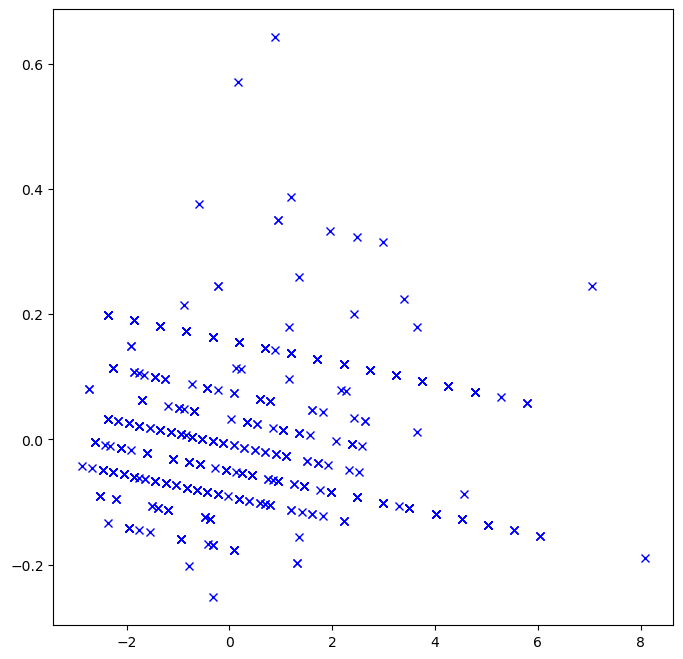

In [13]:
#Plot
plt.figure(figsize=(8, 8))
a = plt.plot(x_2d[:,0],x_2d[:,1],"bx")

# Does there appear to be clear groups?
Yes, there appear to be clear groups.

# Calculate BIC scores
Whats the best value of k? Lets use a grid search algorithm to tell us the best model parameters by calculating the Bayesian Information Criteron (BIC score).

In [14]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(x_scaled)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 7)},
             scoring=<function gmm_bic_score at 0x10443a670>)

In [15]:
bic_scores = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
bic_scores["mean_test_score"] = -bic_scores["mean_test_score"]
bic_scores = bic_scores.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
bic_score = bic_scores.sort_values(by="BIC score").head()
print(bic_score)

   Number of components Type of covariance    BIC score
20                    3               full -8660.011592
21                    4               full -8628.904674
22                    5               full -8569.306193
23                    6               full -8359.131611
19                    2               full -7699.775907


In [16]:
k = bic_score.iloc[0,0]
cov_type = bic_score.iloc[0,1]

In [17]:
k

3

In [18]:
cov_type

'full'

# 3. Run clustering with a Gaussian Mixture Model (GMM) and visualise the results. 

# Cluster and Plot
First try with all the features.

In [19]:
def plot_clusters(clusterer, X):
    labels = clusterer.predict(X)
    pca = PCA(n_components=2)
    x_2d = pca.fit_transform(X)
    plt.scatter(x_2d[:, 0], x_2d[:, 1], c=labels, alpha=0.3)

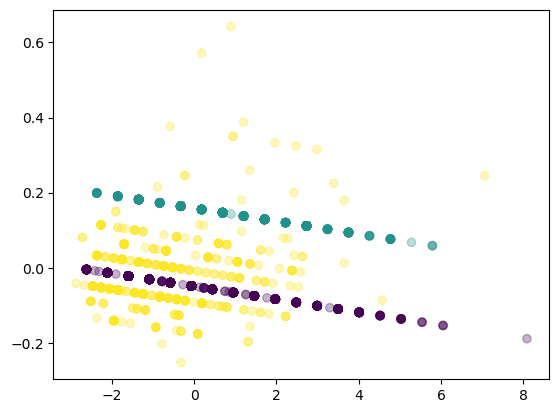

In [20]:
gmm = GaussianMixture(n_components=k, covariance_type=cov_type, random_state=42)
gmm = gmm.fit(x_scaled)
plot_clusters(gmm, x_scaled)

# Reducing Dimensions before clustering¶

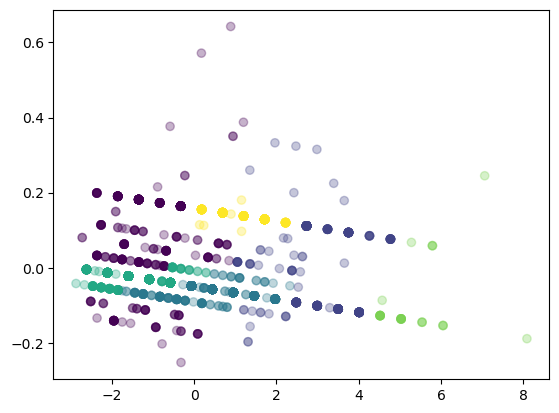

In [21]:
#How many dimensions to reduce to (before clustering)?
num_dimensions = 2 

#Reduce dimensions
pca = PCA(n_components=num_dimensions)
x_less_dimensions = pca.fit_transform(x_scaled)

gmm = GaussianMixture(n_components=6, covariance_type='diag', random_state=42)
gmm = gmm.fit(x_less_dimensions)
plot_clusters(gmm, x_less_dimensions)

# 3. Experiment with some of the things below. It may be that you iterate between this and step 4 a few times, investigating how your clusters are and updating your parameters / dataset.

    * Different values of k (number of clusters)
    
    * Different features (e.g. different columns in your dataset)

    * Different dimensionality reductions (e.g run PCA first, then cluster the principal components as opposed to the original features)



# Different values of k (number of clusters)

In [22]:
k1 = bic_score.iloc[1,0]
cov_type = bic_score.iloc[0,1]

In [23]:
k1

4

In [24]:
cov_type

'full'

In [25]:
def plot_clusters(clusterer, X):
    labels = clusterer.predict(X)
    pca = PCA(n_components=2)
    x_2d = pca.fit_transform(X)
    plt.scatter(x_2d[:, 0], x_2d[:, 1], c=labels, alpha=0.3)

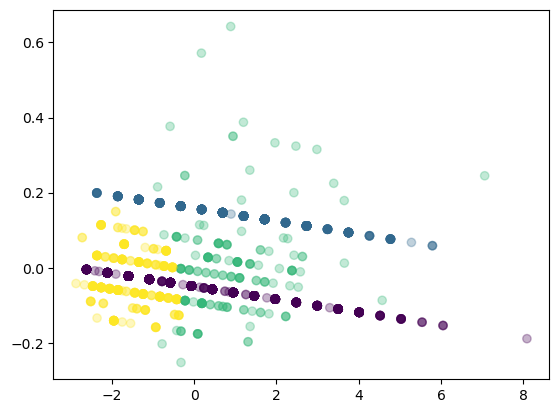

In [26]:
gmm = GaussianMixture(n_components=k1, covariance_type=cov_type, random_state=42)
gmm = gmm.fit(x_scaled)
plot_clusters(gmm, x_scaled)

In [27]:
k2 = bic_score.iloc[2,0]
cov_type = bic_score.iloc[0,1]

In [28]:
k2

5

In [29]:
cov_type

'full'

In [30]:
def plot_clusters(clusterer, X):
    labels = clusterer.predict(X)
    pca = PCA(n_components=2)
    x_2d = pca.fit_transform(X)
    plt.scatter(x_2d[:, 0], x_2d[:, 1], c=labels, alpha=0.3)

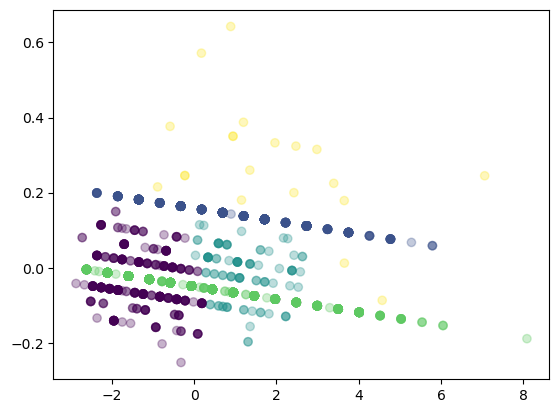

In [31]:
gmm = GaussianMixture(n_components=k2, covariance_type=cov_type, random_state=42)
gmm = gmm.fit(x_scaled)
plot_clusters(gmm, x_scaled)

# Different features (e.g. different columns in your dataset)

In [32]:
k = bic_score.iloc[0,0]
cov_type = bic_score.iloc[0,1]

In [33]:
k

3

In [34]:
cov_type

'full'

In [35]:
#Get reduced dimensions
pca2 = PCA(n_components=3)
x_2d = pca2.fit_transform(x_scaled)

In [36]:
print(x_2d[:,0])
print(x_2d[:,1])

[-0.93648347 -1.59855605 -1.44489212 ... -2.61822667 -0.57888543
 -0.06905012]
[ 0.00813763 -0.02207267 -0.06631123 ... -0.00453735 -0.039608
 -0.04837566]


In [37]:
print(x_2d[:,2])


[ 2.56111300e-13 -4.63060102e-14 -4.36621269e-17 ...  1.11181109e-18
 -3.01984180e-17 -1.22475431e-17]


In [38]:
def plot_clusters(clusterer, X):
    labels = clusterer.predict(X)
    pca2 = PCA(n_components=3)
    x_2d = pca2.fit_transform(X)
    plt.scatter(x_2d[:, 0], x_2d[:, 2], c=labels, alpha=0.3)

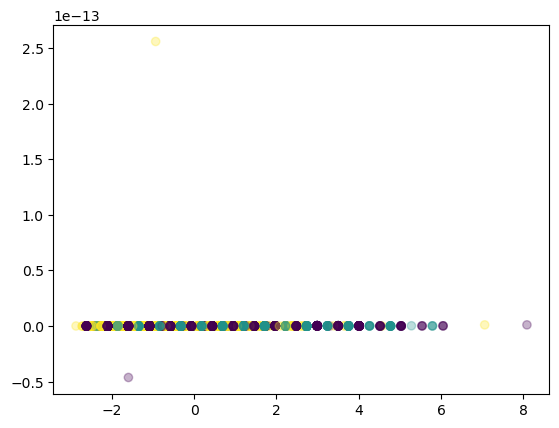

In [39]:
gmm = GaussianMixture(n_components=k, covariance_type=cov_type, random_state=42)
gmm = gmm.fit(x_scaled)
plot_clusters(gmm, x_scaled)

In [40]:
def plot_clusters(clusterer, X):
    labels = clusterer.predict(X)
    pca3 = PCA(n_components=3)
    x_2d = pca3.fit_transform(X)
    plt.scatter(x_2d[:, 1], x_2d[:, 2], c=labels, alpha=0.3)

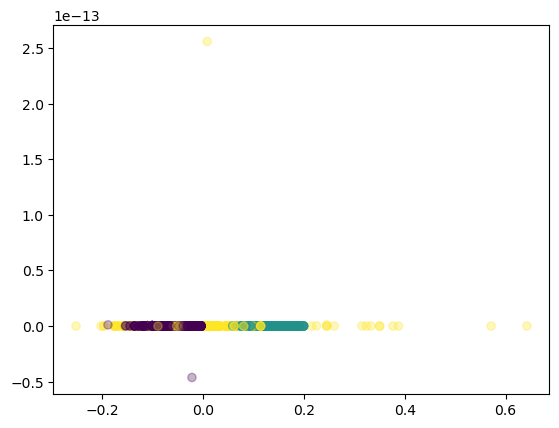

In [41]:
gmm = GaussianMixture(n_components=k, covariance_type=cov_type, random_state=42)
gmm = gmm.fit(x_scaled)
plot_clusters(gmm, x_scaled)

# Different dimensionality reductions (e.g run PCA first, then cluster the principal components as opposed to the original features)

We are clustering based on all of the features, and then reducing down to 2 dimensions to plot.

In [42]:
def plot_clusters(clusterer, X):
    labels = clusterer.predict(X)
    pca = PCA(n_components=2)
    x_2d = pca.fit_transform(X)
    plt.scatter(x_2d[:, 0], x_2d[:, 1], c=labels, alpha=0.3)

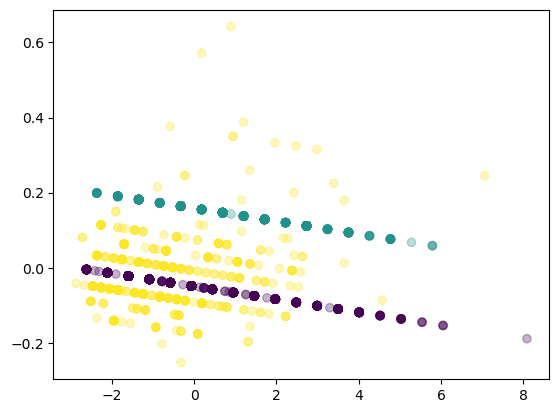

In [43]:
gmm = GaussianMixture(n_components=k, covariance_type=cov_type, random_state=42)
gmm = gmm.fit(x_scaled)
plot_clusters(gmm, x_scaled)

Reducing 2 Dimensions before clustering


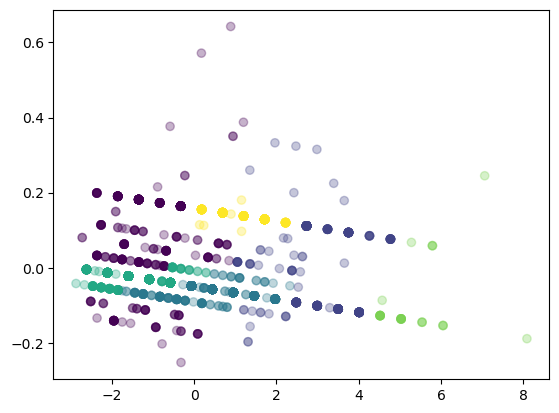

In [44]:
#How many dimensions to reduce to (before clustering)?
num_dimensions = 2 

#Reduce dimensions
pca = PCA(n_components=num_dimensions)
x_less_dimensions = pca.fit_transform(x_scaled)

gmm = GaussianMixture(n_components=6, covariance_type='diag', random_state=42)
gmm = gmm.fit(x_less_dimensions)
plot_clusters(gmm, x_less_dimensions)

We are clustering based on all of the features, and then reducing down to 3 dimensions to plot.

In [45]:
def plot_clusters(clusterer, X):
    labels = clusterer.predict(X)
    pca = PCA(n_components=3)
    x_2d = pca.fit_transform(X)
    plt.scatter(x_2d[:, 0], x_2d[:, 1], c=labels, alpha=0.3)

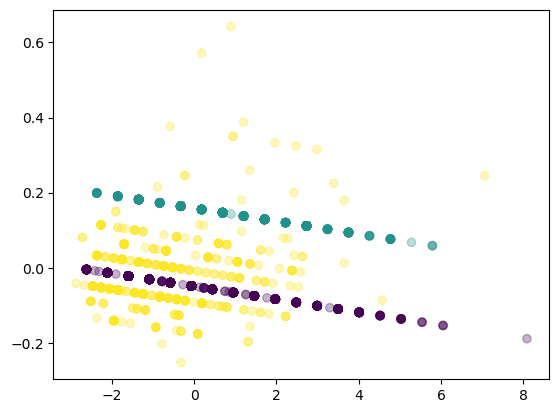

In [46]:
gmm = GaussianMixture(n_components=k, covariance_type=cov_type, random_state=42)
gmm = gmm.fit(x_scaled)
plot_clusters(gmm, x_scaled)

Reducing 3 Dimensions before clustering

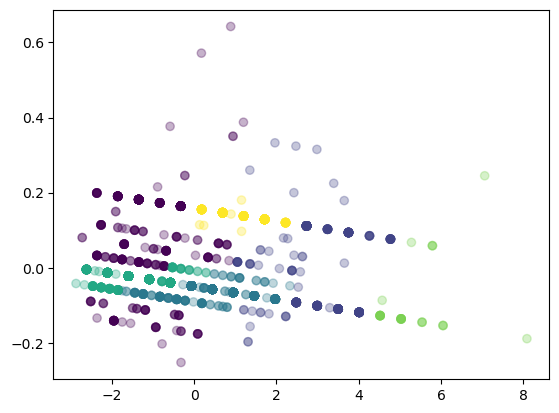

In [47]:
#How many dimensions to reduce to (before clustering)?
num_dimensions1 = 3

#Reduce dimensions
pca = PCA(n_components=num_dimensions1)
x_less_dimensions = pca.fit_transform(x_scaled)

gmm = GaussianMixture(n_components=6, covariance_type='diag', random_state=42)
gmm = gmm.fit(x_less_dimensions)
plot_clusters(gmm, x_less_dimensions)

# Result
Reducing the dimensions before clustering, num_dimensions = 2 ，k=3，x_2d[:, 0], x_2d[:, 1]，appears to give me better results. This cluster is much more compact and is therefore the best one.

# 4. Investigate the examples in your clusters, do they seem to have coherent differences? If so, can you characterise them? You can try the methods below.

If the clusters seem to have no patterns, can you think why this might be, considering your data, and its representation/features?



# Plotting means of features against each other 

Since we are working in two dimensions, we can also plot the mean and standard deviations around each of our Gaussian probability density functions (PDFs) for each of the clusters.

In [48]:
k = bic_score.iloc[0,0]
cov_type = bic_score.iloc[0,1]

In [49]:
k

3

In [50]:
def plot_clusters(clusterer, X):
    labels = clusterer.predict(X)
    pca = PCA(n_components=2)
    x_2d = pca.fit_transform(X)
    plt.scatter(x_2d[:, 0], x_2d[:, 1], c=labels, alpha=0.3)

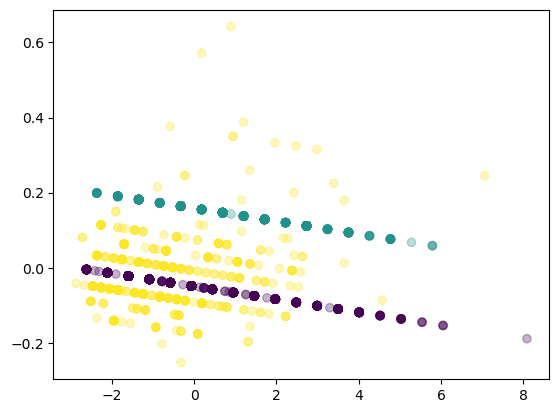

In [51]:
gmm = GaussianMixture(n_components=k, covariance_type=cov_type, random_state=42)
gmm = gmm.fit(x_scaled)
plot_clusters(gmm, x_scaled)

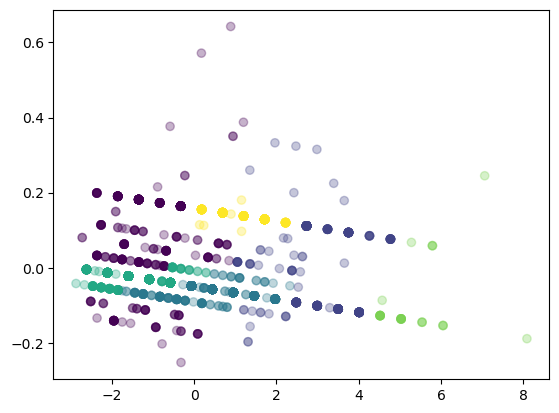

In [52]:
#How many dimensions to reduce to (before clustering)?
num_dimensions = 2 

#Reduce dimensions
pca = PCA(n_components=num_dimensions)
x_less_dimensions = pca.fit_transform(x_scaled)

gmm = GaussianMixture(n_components=6, covariance_type='diag', random_state=42)
gmm = gmm.fit(x_less_dimensions)
plot_clusters(gmm, x_less_dimensions)

In [53]:
from matplotlib.patches import Ellipse

# Code for visualising GMM's from: https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle,  edgecolor='blue', linestyle=':', **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2, alpha=0.2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2, alpha=0.2)
    ax.axis('equal')
    
    w_factor = 0.3 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

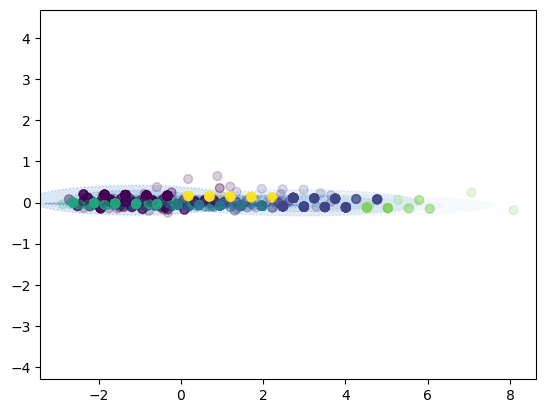

In [56]:
plot_gmm(gmm, x_less_dimensions)

# Examine Clusters
Here we plot a selection of features for each cluster.

Text(0.5, 0, 'cluster number')

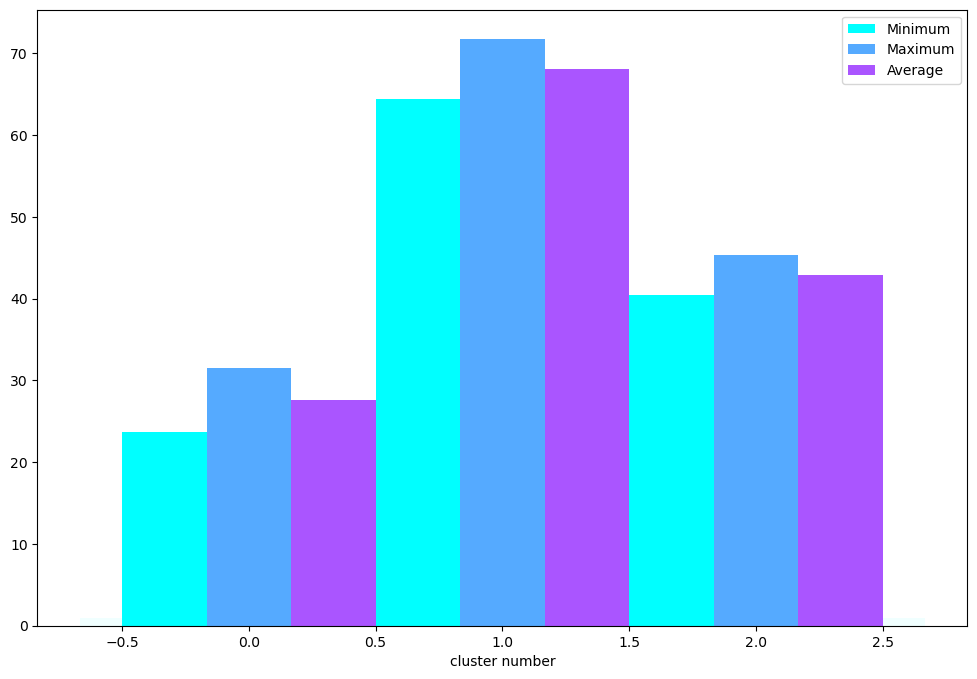

In [57]:
#Add cluster labels as extra column in dataframe
labels = gmm.predict(x_less_dimensions)
x["cluster"] = labels

#Pick some features to plot
features = ['Minimum', 'Maximum', 'Average']
width = 1/(len(features))

fig,ax = plt.subplots(figsize=(12, 8))

for i in range(k):
    ax.bar([i],[1],width=width*4,color = "azure" if i%2==0 else "whitesmoke")

cmap = plt.cm.get_cmap('cool')
#Iterate through features
for index, f in enumerate(features):
    #Get mean for each feature for each cluster
    data = [np.mean(x[x["cluster"]==i][f]) for i in range(k)]
    
    x_vals = np.arange(len(data)) + (width*index) - 0.5 + width/2
    
    #Plot this feature for each cluster
    ax.bar(x_vals, data, width = width, label = f, color = cmap(index/len(features)))
    
ax.legend()
ax.set_xlabel("cluster number")

In [58]:
print(x[x['cluster'] == 0])

            Date Unit  Minimum  Maximum  Average  Market  cluster
0     2013-06-16   Kg       26       32     29.0  Tomato        0
8     2013-06-27   Kg       18       24     21.0  Tomato        0
15    2013-07-05   Kg       18       24     21.0  Tomato        0
37    2013-08-02   Kg       25       35     30.0  Tomato        0
40    2013-08-06   Kg       28       34     31.0  Tomato        0
...          ...  ...      ...      ...      ...     ...      ...
2706  2021-04-09   Kg       30       40     35.0  Tomato        0
2707  2021-04-10   Kg       30       40     35.0  Tomato        0
2708  2021-04-11   Kg       25       35     30.0  Tomato        0
2709  2021-04-12   Kg       25       35     30.0  Tomato        0
2726  2021-04-29   Kg       30       40     35.0  Tomato        0

[409 rows x 7 columns]


In [59]:
print(x[x['cluster'] == 1])

            Date Unit  Minimum  Maximum  Average  Market  cluster
22    2013-07-16   Kg       48       52     50.0  Tomato        1
86    2013-10-06   Kg       65       75     70.0  Tomato        1
87    2013-10-07   Kg       60       70     65.0  Tomato        1
89    2013-10-09   Kg       75       80     77.5  Tomato        1
90    2013-10-10   Kg       75       80     77.5  Tomato        1
...          ...  ...      ...      ...      ...     ...      ...
2546  2020-10-28   Kg       60       65     62.5  Tomato        1
2553  2020-11-04   Kg       55       62     58.5  Tomato        1
2577  2020-11-28   Kg       45       52     48.5  Tomato        1
2581  2020-12-02   Kg       48       55     51.5  Tomato        1
2590  2020-12-11   Kg       45       52     48.5  Tomato        1

[321 rows x 7 columns]


In [60]:
print(x[x['cluster'] == 2])

            Date Unit  Minimum  Maximum  Average  Market  cluster
2     2013-06-18   Kg       22       26     24.0  Tomato        2
3     2013-06-19   Kg       24       28     26.0  Tomato        2
4     2013-06-20   Kg       22       26     24.0  Tomato        2
9     2013-06-28   Kg       24       28     26.0  Tomato        2
19    2013-07-12   Kg       44       48     46.0  Tomato        2
...          ...  ...      ...      ...      ...     ...      ...
2695  2021-03-29   Kg       45       50     47.5  Tomato        2
2696  2021-03-30   Kg       45       50     47.5  Tomato        2
2697  2021-03-31   Kg       45       50     47.5  Tomato        2
2701  2021-04-04   Kg       45       50     47.5  Tomato        2
2740  2021-05-13   Kg       35       40     37.5  Tomato        2

[689 rows x 7 columns]


# If the clusters seem to have no patterns, can you think why this might be, considering your data, and its representation/features?
Noise in the data: Data may contain noise or outliers that are causing the clustering algorithm to produce seemingly random or unstructured clusters. This can happen if your data is incomplete, contains errors or inaccuracies, or if there are natural variations or anomalies in the data that are not related to any underlying patterns.

Insufficient features: Your data may not contain enough relevant features to enable meaningful clustering. If the features you have selected are not strongly correlated with the patterns you are trying to uncover, then the clustering algorithm may not be able to identify any meaningful structure in the data.

Data is truly random: In some cases, the data itself may simply be random or stochastic, with no underlying patterns or structure to uncover. 

To determine the cause of the apparent lack of patterns in clusters, it may be helpful to examine data more closely, try different clustering algorithms.